In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
def angular(phi,l,m):
    return np.sqrt(2.)*np.cos(l*phi+m*np.pi/(2.))

class poly_radial_basis():
    def __init__(self,n_max=3,r_cut=2.0,n_points=10000):
        self.n_max = n_max
        self.r_cut = r_cut
        self.n_points = n_points
        self.get_beta()
    def poly(self,r,n):    
        return (r-self.r_cut)**(n+2)
    def get_beta(self):    
        S = np.zeros((self.n_max,self.n_max))
        r = np.linspace(0,self.r_cut,self.n_points)
        for ni in range(self.n_max):
            for nj in range(self.n_max):
                S[ni,nj] = np.sum(self.poly(r,ni)*self.poly(r,nj))/self.n_points
        self.beta = np.linalg.inv(sqrtm(S))
    def evaluate(self,r,n):
        res = np.zeros_like(r)
        for ni in range(self.n_max):
            res += self.beta[n,ni]*self.poly(r,ni)
        res[r>self.r_cut] = 0.0
        return res

class gauss_radial_basis():
    def __init__(self,n_max=3,r_cut=2.0,n_points=10000):
        self.n_max = n_max
        self.r_cut = r_cut
        self.sigma = r_cut/n_max
        self.centers = np.linspace(0,r_cut,n_max+2)
        self.n_points = n_points
        self.get_beta()
    def gauss(self,r,n):    
        return np.exp(-(r-self.centers[n+1])**2/(2.*self.sigma**2))
    def get_beta(self):    
        S = np.zeros((self.n_max,self.n_max))
        r = np.linspace(0,self.r_cut,self.n_points)
        for ni in range(self.n_max):
            for nj in range(self.n_max):
                S[ni,nj] = np.sum(self.gauss(r,ni)*self.gauss(r,nj))/self.n_points
        self.beta = np.linalg.inv(sqrtm(S))
    def evaluate(self,r,n):
        res = np.zeros_like(r)
        for ni in range(self.n_max):
            res += self.beta[n,ni]*self.gauss(r,ni)
        res[r>self.r_cut] = 0.0
        return res    
    
def phi2xy(phi):
    return np.cos(phi), np.sin(phi)

def xy2phi(x,y):
    return np.arctan2(x,y)

def basis(xx,yy,rad_basis,n=1,l=1,m=0):
    r = np.sqrt(xx**2+yy**2)
    phi = xy2phi(xx,yy)
    return angular(phi,l,m)*rad_basis.evaluate(r,n)

def gaussian(x,y,xx,yy,sigma_atom=0.5,r_cut=2.0):
    r = np.sqrt(xx**2+yy**2)
    res = np.exp(-((xx-x)**2+(yy-y)**2)/(sigma_atom**2))
    #res[r>r_cut] = 0.0
    return res

def shape_function(xx,yy,r_cut,d_trans=0.5):
    r = np.sqrt(xx**2+yy**2)
    res = 0.5*(np.cos(np.pi*(r-r_cut+d_trans)/d_trans)+1.)
    res[r>r_cut] = 0.0
    res[r<r_cut-d_trans] = 1.0
    return res

def neighborhood(xy,xx,yy,sigma_atom=0.5,r_cut=2.0,d_trans=0.5):
    n_atoms = xy.shape[0]
    rho = np.zeros_like(xx)
    for iatom in range(n_atoms):
        rho += gaussian(xy[iatom,0],xy[iatom,1],xx,yy,sigma_atom=sigma_atom,r_cut=r_cut)
    f_shape = shape_function(xx,yy,r_cut,d_trans=d_trans)
    return rho*f_shape

def gen_basis_dict(n_max=4,l_max=4):
    basisset = {}
    for n in range(n_max):
        for l in range(l_max):
            if l>0:
                for m in [0,1]:
                    key = f'n={n} l={l} m={m}'
                    basisset[key] = (n,l,m)
            else:
                key = f'n={n} l={l} m={0}'
                basisset[key] = (n,l,0)
    return basisset

def reshape_mosaic(basis_dict,n_max,l_max):
    keys = np.array(list(basis_dict.keys()))
    return keys.reshape(n_max,l_max*2-1)

In [3]:
N_points = 10000
phirange = np.linspace(0,2*np.pi,N_points)
#plt.plot(phirange,angular(phirange,0))
#plt.plot(phirange,angular(phirange,1))
#plt.plot(phirange,angular(phirange,2))
for l1 in [3]:
    for l2 in [3]:
        for m1 in np.arange(0,2,1):
            for m2 in np.arange(0,2,1):
                print(l1,l2,m1,m2,np.round(np.sum(angular(phirange,l1,m1)*angular(phirange,l2,m2)/N_points),2))
                #plt.plot(phirange,angular(phirange,l1,m1))
                #plt.plot(phirange,angular(phirange,l2,m2))
                #plt.show()

3 3 0 0 1.0
3 3 0 1 0.0
3 3 1 0 0.0
3 3 1 1 1.0


0 0 1.0
1 0 -0.0
1 1 1.0
2 0 -0.0
2 1 -0.0
2 2 1.0
3 0 -0.0
3 1 -0.0
3 2 -0.0
3 3 1.0
4 0 -0.0
4 1 -0.0
4 2 -0.0
4 3 -0.0
4 4 1.0
5 0 -0.0
5 1 -0.0
5 2 -0.0
5 3 -0.0
5 4 -0.0
5 5 1.0


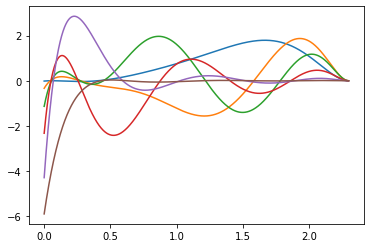

In [4]:
rcut = 2.3
rrange = np.linspace(0,rcut,N_points)

rad_basis = poly_radial_basis(n_max=6,r_cut=rcut)

for ni in range(6):
    for nj in range(ni+1):
        print(ni,nj,np.round(np.sum(rad_basis.evaluate(rrange,ni)*rad_basis.evaluate(rrange,nj))/N_points,2))
plt.plot(rrange,rad_basis.evaluate(rrange,0))
plt.plot(rrange,rad_basis.evaluate(rrange,1))
plt.plot(rrange,rad_basis.evaluate(rrange,2))
plt.plot(rrange,rad_basis.evaluate(rrange,3))
plt.plot(rrange,rad_basis.evaluate(rrange,4))
plt.plot(rrange,rad_basis.evaluate(rrange,5))

#for n1 in range(5):
    #for n2 in range(n1+1):
        #print(n1,n2,np.round(np.sum(radial(rrange,n1,rcut=rcut)*radial(rrange,n2,rcut=rcut))/N_points,2))
        #plt.plot(rrange,radial(rrange,n1,rcut=rcut))
        #plt.plot(rrange,radial(rrange,n2,rcut=rcut))
        #plt.show()

0 0 1.0
1 0 0.0
1 1 1.0
2 0 0.0
2 1 0.0
2 2 1.0
3 0 0.0
3 1 -0.0
3 2 0.0
3 3 1.0
4 0 0.0
4 1 0.0
4 2 -0.0
4 3 0.0
4 4 1.0
5 0 0.0
5 1 -0.0
5 2 0.0
5 3 -0.0
5 4 -0.0
5 5 1.0


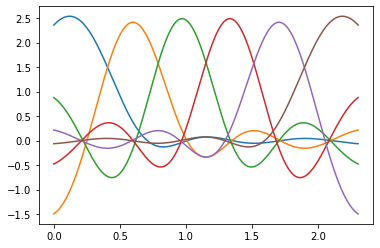

In [5]:
rcut = 2.3
rrange = np.linspace(0,rcut,N_points)

rad_basis = gauss_radial_basis(n_max=6,r_cut=rcut)

for ni in range(6):
    for nj in range(ni+1):
        print(ni,nj,np.round(np.sum(rad_basis.evaluate(rrange,ni)*rad_basis.evaluate(rrange,nj))/N_points,2))
plt.plot(rrange,rad_basis.evaluate(rrange,0))
plt.plot(rrange,rad_basis.evaluate(rrange,1))
plt.plot(rrange,rad_basis.evaluate(rrange,2))
plt.plot(rrange,rad_basis.evaluate(rrange,3))
plt.plot(rrange,rad_basis.evaluate(rrange,4))
plt.plot(rrange,rad_basis.evaluate(rrange,5))

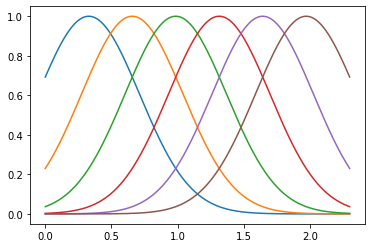

In [6]:
for n in range(6):
    plt.plot(rrange,rad_basis.gauss(rrange,n))

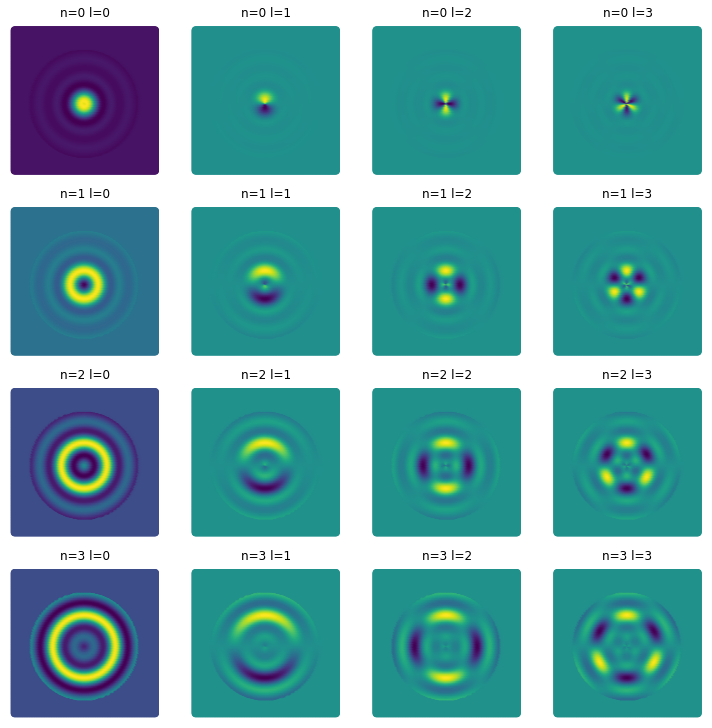

In [31]:
x = np.linspace(-3,3,200)
y = np.linspace(-3,3,200)
xx,yy = np.meshgrid(x,y,sparse=False)

fig = plt.figure(constrained_layout=True,frameon=False,figsize=(10,10))

ax_dict = fig.subplot_mosaic(
    [
        ["n=0 l=0", "n=0 l=1", "n=0 l=2", "n=0 l=3"],
        ["n=1 l=0", "n=1 l=1", "n=1 l=2", "n=1 l=3"],
        ["n=2 l=0", "n=2 l=1", "n=2 l=2", "n=2 l=3"],
        ["n=3 l=0", "n=3 l=1", "n=3 l=2", "n=3 l=3"],
    ],
)

ax_dict["n=0 l=0"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=0,l=0,m=0))
ax_dict["n=0 l=1"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=0,l=1,m=0))
ax_dict["n=0 l=2"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=0,l=2,m=0))
ax_dict["n=0 l=3"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=0,l=3,m=0))
ax_dict["n=1 l=0"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=1,l=0,m=0))
ax_dict["n=1 l=1"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=1,l=1,m=0))
ax_dict["n=1 l=2"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=1,l=2,m=0))
ax_dict["n=1 l=3"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=1,l=3,m=0))
ax_dict["n=2 l=0"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=2,l=0,m=0))
ax_dict["n=2 l=1"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=2,l=1,m=0))
ax_dict["n=2 l=2"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=2,l=2,m=0))
ax_dict["n=2 l=3"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=2,l=3,m=0))
ax_dict["n=3 l=0"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=3,l=0,m=0))
ax_dict["n=3 l=1"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=3,l=1,m=0))
ax_dict["n=3 l=2"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=3,l=2,m=0))
ax_dict["n=3 l=3"].scatter(xx,yy,c=basis(xx,yy,rad_basis,n=3,l=3,m=0))

for key in ax_dict.keys():
    ax_dict[key].axis('off')
    ax_dict[key].set_title(key)
    ax_dict[key].set_aspect('equal')

plt.savefig('SOAP_basis_functions.png',bbox_inches='tight')
plt.show()
#for ni in range(6):
#    plt.scatter(xx,yy,c=basis(xx,yy,rad_basis,n=ni,l=1,m=0))
#    plt.show()

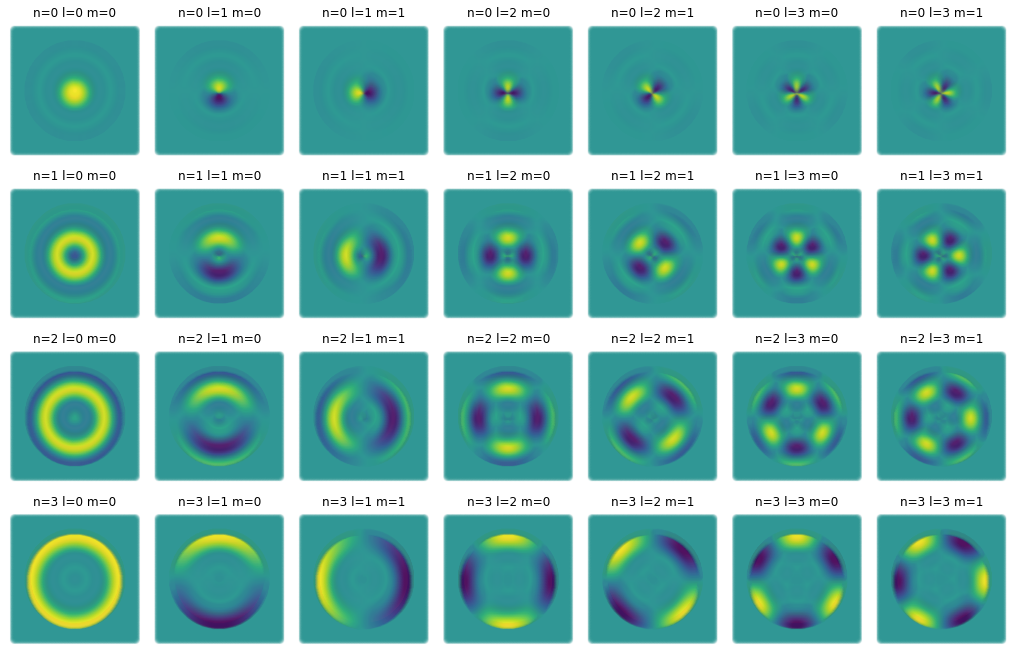

In [57]:
x = np.linspace(-3,3,200)
y = np.linspace(-3,3,200)
xx,yy = np.meshgrid(x,y,sparse=False)

n_max = 4
l_max = 4
rcut = 2.3
#rrange = np.linspace(0,rcut,N_points)

rad_basis = gauss_radial_basis(n_max=n_max,r_cut=rcut)

basis_dict = gen_basis_dict(n_max=n_max,l_max=l_max)
#print(basis_dict)
keys_mosaic = reshape_mosaic(basis_dict,n_max,l_max)

fig = plt.figure(constrained_layout=True,frameon=False,figsize=(14,9))

ax_dict = fig.subplot_mosaic(
    keys_mosaic,
)

f_min = []
f_max = []
fs    = []

for key in basis_dict.keys():
    n,l,m = basis_dict[key]
    f = basis(xx,yy,rad_basis,n=n,l=l,m=m)
    fs.append(f)
    f_min.append(np.min(f))
    f_max.append(np.max(f))
    #ax_dict[key].scatter(xx,yy,c=f,alpha=0.05)
    ax_dict[key].axis('off')
    ax_dict[key].set_title(key)
    ax_dict[key].set_aspect('equal')
    
f_min = min(f_min)
f_max = max(f_max)

for i,key in enumerate(basis_dict.keys()):
    ax_dict[key].scatter(xx,yy,c=fs[i],alpha=0.05,vmin=f_min,vmax=f_max)
    
plt.savefig('SOAP_basis_functions_scale.png',bbox_inches='tight')
plt.show()

SOAP_rotate_density_1.png


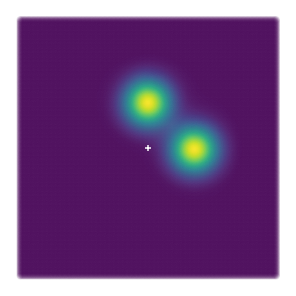

In [58]:
rcut=2.3
xy = np.array([[0.,1.],[1.,0.]])
rho = neighborhood(xy,xx,yy,r_cut=rcut)
show_density(xy,N_points=200,r_cut=rcut,filename=f"SOAP_rotate_density_1.png")

#plt.scatter(xy[:,0],xy[:,1])
#xx,yy = np.meshgrid(x,y,sparse=False)
#rho = neighborhood(xy,xx,yy,r_cut=rcut)
#plt.scatter(xx,yy,c=rho,alpha=0.1)
#plt.scatter(xy[:,0],xy[:,1])


[0.01429167192535534, 0.006056559984830554, -0.006056559984830556, -1.7911019889460532e-19, -1.147094895236878e-18, 0.002144374531226152, 0.0021443745312261526, 0.0666212355472078, 0.030888195630955743, -0.030888195630955732, -1.528291382335567e-19, -3.962626250076353e-18, 0.017128695573595924, 0.017128695573595927, 0.04765458302171242, 0.022738509580729826, -0.022738509580729822, -8.1601392309949e-19, -7.854970306637239e-19, 0.015609524431388178, 0.01560952443138818, 0.005140263397050547, 0.0024704982594795522, -0.0024704982594795522, 1.3322676295501877e-19, -1.7695519884602462e-19, 0.0018286206461299536, 0.0018286206461299531]


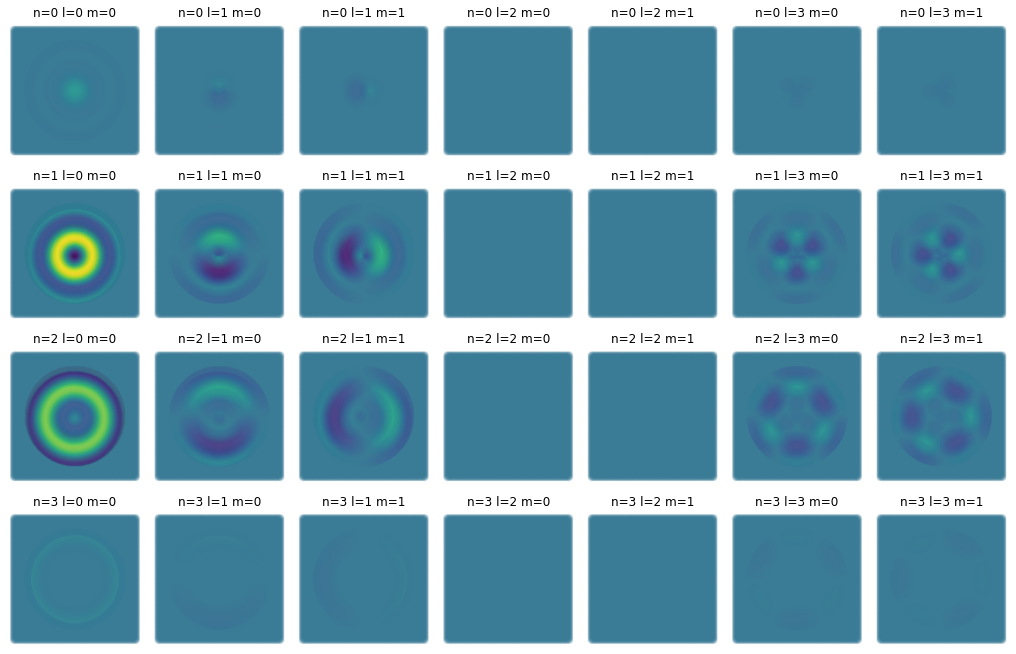

In [59]:
keys_mosaic = reshape_mosaic(basis_dict,n_max,l_max)

fig = plt.figure(constrained_layout=True,frameon=False,figsize=(14,9))

ax_dict = fig.subplot_mosaic(
    keys_mosaic,
)

N_grid = xx.shape[0]*xx.shape[1]
coef = []
cfs  = []
f_min = []
f_max = []
for i,key in enumerate(basis_dict.keys()):
    c = np.sum(fs[i]*rho)/N_grid
    coef.append(c)
    cfs.append(c*fs[i])
    f_min.append(np.min(c*fs[i]))
    f_max.append(np.max(c*fs[i]))
    ax_dict[key].axis('off')
    ax_dict[key].set_title(key)
    ax_dict[key].set_aspect('equal')

f_min = min(f_min)
f_max = max(f_max)    
print(coef)    
for i,key in enumerate(basis_dict.keys()):    
    ax_dict[key].scatter(xx,yy,c=cfs[i],alpha=0.05,vmin=f_min,vmax=f_max)
plt.savefig('SOAP_basis_functions_weight_rotate1.png',bbox_inches='tight')
plt.show()

SOAP_rotate_density_2.png


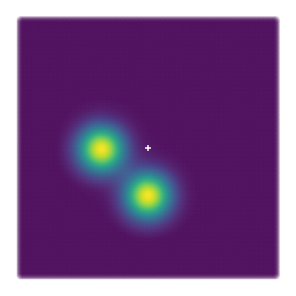

In [60]:
xy = np.array([[0.,-1.],[-1.,0.]])
rho = neighborhood(xy,xx,yy,r_cut=rcut)
show_density(xy,N_points=200,r_cut=rcut,filename=f"SOAP_rotate_density_2.png")

#plt.scatter(xy[:,0],xy[:,1])
#xx,yy = np.meshgrid(x,y,sparse=False)
#rho = neighborhood(xy,xx,yy,r_cut=rcut)
#plt.scatter(xx,yy,c=rho,alpha=0.1)
#plt.scatter(xy[:,0],xy[:,1])

[0.01429167192535534, -0.006056559984830554, 0.0060565599848305535, 2.4591754562308006e-19, 1.488396273125827e-18, -0.0021443745312261535, -0.0021443745312261535, 0.06662123554720781, -0.03088819563095574, 0.03088819563095574, 8.506887123378923e-19, 2.2753283605745512e-18, -0.017128695573595927, -0.017128695573595927, 0.04765458302171242, -0.02273850958072983, 0.022738509580729815, 2.9087345983899502e-18, 6.070190412790815e-19, -0.01560952443138818, -0.01560952443138818, 0.0051402633970505495, -0.002470498259479554, 0.002470498259479554, -1.9381992128738927e-19, 2.0514487884712137e-19, -0.0018286206461299546, -0.0018286206461299542]


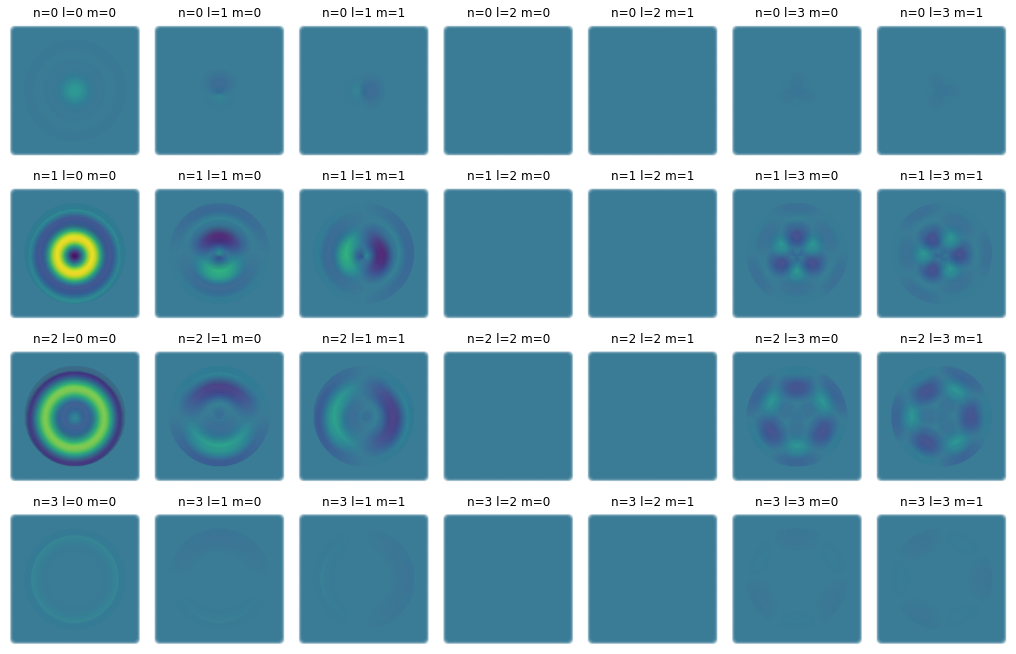

In [61]:
keys_mosaic = reshape_mosaic(basis_dict,n_max,l_max)

fig = plt.figure(constrained_layout=True,frameon=False,figsize=(14,9))

ax_dict = fig.subplot_mosaic(
    keys_mosaic,
)

N_grid = xx.shape[0]*xx.shape[1]
coef = []
cfs  = []
f_min = []
f_max = []
for i,key in enumerate(basis_dict.keys()):
    c = np.sum(fs[i]*rho)/N_grid
    coef.append(c)
    cfs.append(c*fs[i])
    f_min.append(np.min(c*fs[i]))
    f_max.append(np.max(c*fs[i]))
    ax_dict[key].axis('off')
    ax_dict[key].set_title(key)
    ax_dict[key].set_aspect('equal')

f_min = min(f_min)
f_max = max(f_max)    
print(coef)    
for i,key in enumerate(basis_dict.keys()):    
    ax_dict[key].scatter(xx,yy,c=cfs[i],alpha=0.05,vmin=f_min,vmax=f_max)
plt.savefig('SOAP_basis_functions_weight_rotate2.png',bbox_inches='tight')
plt.show()

In [44]:
xy = np.array([[0.,1.],[-1.,0.]])
plt.scatter(xy[:,0],xy[:,1])
xx,yy = np.meshgrid(x,y,sparse=False)
rho = neighborhood(xy,xx,yy,r_cut=rcut)
plt.scatter(xx,yy,c=rho,alpha=0.1)
plt.scatter(xy[:,0],xy[:,1])

In [45]:
keys_mosaic = reshape_mosaic(basis_dict,n_max,l_max)

fig = plt.figure(constrained_layout=True,frameon=False)#,figsize=(14,10))

ax_dict = fig.subplot_mosaic(
    keys_mosaic,
)

N_grid = xx.shape[0]*xx.shape[1]
coef = []
cfs  = []
f_min = []
f_max = []
for i,key in enumerate(basis_dict.keys()):
    c = np.sum(fs[i]*rho)/N_grid
    coef.append(c)
    cfs.append(c*fs[i])
    f_min.append(np.min(c*fs[i]))
    f_max.append(np.max(c*fs[i]))
    ax_dict[key].axis('off')
    ax_dict[key].set_title(key)
    ax_dict[key].set_aspect('equal')

f_min = min(f_min)
f_max = max(f_max)    
print(coef)    
for i,key in enumerate(basis_dict.keys()):    
    ax_dict[key].scatter(xx,yy,c=cfs[i],alpha=0.05,vmin=f_min,vmax=f_max)
plt.savefig('SOAP_basis_functions_weight_rotate_2.png',bbox_inches='tight')
plt.show()

[0.014291671925355336, 0.006056559984830554, 0.006056559984830554, 8.86703904745545e-19, 1.2550343283127607e-19, 0.002144374531226152, -0.0021443745312261526, 0.0666212355472078, 0.03088819563095574, 0.03088819563095574, -5.837344496661956e-18, 1.0320920067682383e-18, 0.01712869557359592, -0.017128695573595927, 0.047654583021712424, 0.022738509580729822, 0.022738509580729826, 2.0261570199409106e-18, -4.596320314981186e-19, 0.01560952443138818, -0.015609524431388178, 0.005140263397050547, 0.0024704982594795522, 0.0024704982594795535, -2.6645352591003755e-19, -9.972029949565416e-20, 0.0018286206461299531, -0.0018286206461299542]


In [47]:
def reconstruction_delta(xy,N_points=50,n_max=4,l_max=4,r_cut=2.3,filename=None):
    N_grid = N_points**2
    xlim = rcut*1.2
    x = np.linspace(-xlim,xlim,N_points)
    y = np.linspace(-xlim,xlim,N_points)
    xx,yy = np.meshgrid(x,y,sparse=False)
    xx_delta = np.array([xy[i][0] for i in range(xy.shape[0])])
    yy_delta = np.array([xy[i][1] for i in range(xy.shape[0])])
    
    rad_basis = gauss_radial_basis(n_max=n_max,r_cut=r_cut)
    basis_dict = gen_basis_dict(n_max=n_max,l_max=l_max)
    
    rho_delta = np.ones_like(xx_delta)
    rho = np.zeros_like(xx)#neighborhood(xy,xx,yy,r_cut=r_cut)
    recon = np.zeros_like(rho)
    
    for key in basis_dict.keys():
        n,l,m = basis_dict[key]
        f = basis(xx,yy,rad_basis,n=n,l=l,m=m)
        f_delta = basis(xx_delta,yy_delta,rad_basis,n=n,l=l,m=m)
        c = np.sum(f_delta*rho_delta)
        recon += c*f

    fig = plt.figure(constrained_layout=True,frameon=False)

    ax_dict = fig.subplot_mosaic(
        [["Rho", "Recon"]],
    )

    ax_dict["Rho"].axis('off')
    ax_dict["Rho"].set_title('Original')
    ax_dict["Rho"].set_aspect('equal')
    ax_dict["Rho"].scatter(xx,yy,c=rho,alpha=0.1)
    ax_dict["Rho"].scatter(xx_delta,yy_delta,c='w',alpha=1.0)
    ax_dict["Rho"].scatter([0.0],[0.0],c='w',marker='+',alpha=1.0)

    ax_dict["Recon"].axis('off')
    ax_dict["Recon"].set_title(f'Reconstruction \n n_max={n_max} l_max={l_max}')
    ax_dict["Recon"].set_aspect('equal')
    ax_dict["Recon"].scatter(xx,yy,c=recon,alpha=0.1)
    ax_dict["Recon"].scatter([0.0],[0.0],c='w',marker='+',alpha=1.0)
    
    if filename == None:
        plt.show()
    else:
        print(filename)
        plt.savefig(filename,bbox_inches='tight')
        plt.show()

def reconstruction(xy,N_points=50,n_max=4,l_max=4,r_cut=2.3,filename=None):
    N_grid = N_points**2
    xlim = rcut*1.2
    x = np.linspace(-xlim,xlim,N_points)
    y = np.linspace(-xlim,xlim,N_points)
    xx,yy = np.meshgrid(x,y,sparse=False)
    
    rad_basis = gauss_radial_basis(n_max=n_max,r_cut=r_cut)
    basis_dict = gen_basis_dict(n_max=n_max,l_max=l_max)
    
    rho = neighborhood(xy,xx,yy,r_cut=r_cut)
    recon = np.zeros_like(rho)
    
    for key in basis_dict.keys():
        n,l,m = basis_dict[key]
        f = basis(xx,yy,rad_basis,n=n,l=l,m=m)
        c = np.sum(f*rho)/N_grid
        recon += c*f

    fig = plt.figure(constrained_layout=True,frameon=False)

    ax_dict = fig.subplot_mosaic(
        [["Rho", "Recon"]],
    )

    ax_dict["Rho"].axis('off')
    ax_dict["Rho"].set_title('Original')
    ax_dict["Rho"].set_aspect('equal')
    ax_dict["Rho"].scatter(xx,yy,c=rho,alpha=0.1)
    ax_dict["Rho"].scatter([0.0],[0.0],c='w',marker='+',alpha=1.0)

    ax_dict["Recon"].axis('off')
    ax_dict["Recon"].set_title(f'Reconstruction \n n_max={n_max} l_max={l_max}')
    ax_dict["Recon"].set_aspect('equal')
    ax_dict["Recon"].scatter(xx,yy,c=recon,alpha=0.1)
    ax_dict["Recon"].scatter([0.0],[0.0],c='w',marker='+',alpha=1.0)
    
    if filename == None:
        plt.show()
    else:
        print(filename)
        plt.savefig(filename,bbox_inches='tight')
        plt.show()
        
def show_density(xy,N_points=50,r_cut=2.3,filename=None):
    N_grid = N_points**2
    xlim = rcut*1.2
    x = np.linspace(-xlim,xlim,N_points)
    y = np.linspace(-xlim,xlim,N_points)
    xx,yy = np.meshgrid(x,y,sparse=False)
    
    rho = neighborhood(xy,xx,yy,r_cut=r_cut)

    fig = plt.figure(constrained_layout=True,frameon=False)

    ax_dict = fig.subplot_mosaic(
        [["Rho"]],
    )

    ax_dict["Rho"].axis('off')
    #ax_dict["Rho"].set_title('Original')
    ax_dict["Rho"].set_aspect('equal')
    ax_dict["Rho"].scatter(xx,yy,c=rho,alpha=0.1)
    ax_dict["Rho"].scatter([0.0],[0.0],c='w',marker='+',alpha=1.0)
    
    if filename == None:
        plt.show()
    else:
        print(filename)
        plt.savefig(filename,bbox_inches='tight')
        plt.show()
    
def get_powerspectrum(xy,N_points=50,n_max=4,l_max=4,r_cut=2.3):
    N_grid = N_points**2
    xlim = rcut*1.2
    x = np.linspace(-xlim,xlim,N_points)
    y = np.linspace(-xlim,xlim,N_points)
    xx,yy = np.meshgrid(x,y,sparse=False)
    
    rad_basis = gauss_radial_basis(n_max=n_max,r_cut=r_cut)
    basis_dict = gen_basis_dict(n_max=n_max,l_max=l_max)
    
    rho = neighborhood(xy,xx,yy,r_cut=r_cut)
    #recon = np.zeros_like(rho)
    c_nlm = np.zeros((n_max,l_max,2))
    
    for key in basis_dict.keys():
        n,l,m = basis_dict[key]
        f = basis(xx,yy,rad_basis,n=n,l=l,m=m)
        c = np.sum(f*rho)/N_grid
        c_nlm[n,l,m] = c

    p = []    
    for n1 in range(n_max):
        for n2 in range(n_max):
            for l in range(l_max):
                pi = 0.0
                for m in range(2):
                    pi += c_nlm[n1,l,m]*c_nlm[n2,l,m]
                p.append(pi)
    p = np.array(p)
    p /= np.linalg.norm(p)
    return p
        #recon += c*f

In [50]:
phis = np.linspace(-np.pi/2.,np.pi/2.,41)
ps   = []
for i,phi in enumerate(phis):
    xy = np.array([phi2xy(phi),[-1,0.0]])
    #show_density(xy,N_points=150,r_cut=2.3)
    ps.append(get_powerspectrum(xy,N_points=150,n_max=6,l_max=4,r_cut=2.3))

linear = []
quadratic = []

for i,p in enumerate(ps):
    linear.append(np.dot(p,ps[0]))
    quadratic.append(np.dot(p,ps[0])**2)

plt.plot(phis,linear)
plt.plot(phis,quadratic)


#xy = np.array([[0.,1.],[-1.,0.]])
#p1 = get_powerspectrum(xy,N_points=150,n_max=4,l_max=3)
#xy = np.array([[0.,-1.],[-1.,0.]])
#p2 = get_powerspectrum(xy,N_points=150,n_max=4,l_max=3)
#print(np.sum(p1),np.sum(p2),np.sum(p1-p2))


In [55]:
linear = []
quadratic = []

for i,p in enumerate(ps):
    linear.append(np.dot(p,ps[0]))
    quadratic.append(np.dot(p,ps[0])**2)

plt.figure(figsize=(12, 4), dpi=80)
plt.plot(phis,linear)
plt.xlabel("$\phi$ / radians",fontsize=16)
plt.ylabel(r"Similarity with $\phi=-\frac{\pi}{2}$",fontsize=16)
plt.xticks([-np.pi/2,-np.pi/4,0.0,np.pi/4,np.pi/2],[r"$-\frac{\pi}{2}$",r"$-\frac{\pi}{4}$",r"0",r"$\frac{\pi}{4}$",r"$\frac{\pi}{2}$"],fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-np.pi/2,np.pi/2])
plt.savefig('SOAP_similarity_plot.png',bbox_inches='tight')
plt.show()

#plt.plot(phis,quadratic)


dimer_density_phi_-1.571.png


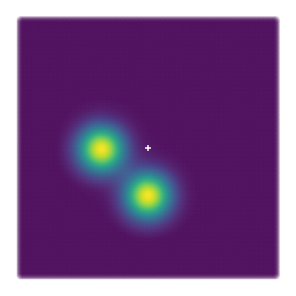

dimer_density_phi_-0.785.png


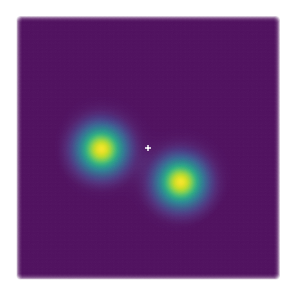

dimer_density_phi_0.0.png


dimer_density_phi_0.785.png


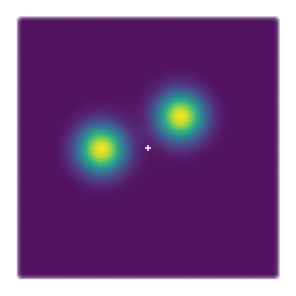

dimer_density_phi_1.571.png


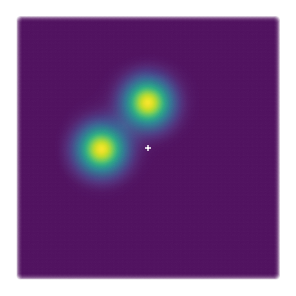

In [48]:
phis = np.linspace(-np.pi/2.,np.pi/2.,5)
#ps   = []
for i,phi in enumerate(phis):
    xy = np.array([phi2xy(phi),[-1,0.0]])
    show_density(xy,N_points=200,r_cut=2.3,filename=f"dimer_density_phi_{np.round(phi,3)}.png")
    #ps.append(get_powerspectrum(xy,N_points=150,n_max=6,l_max=4,r_cut=2.3))

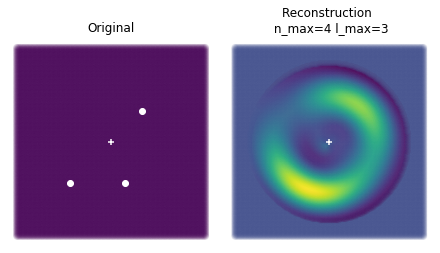

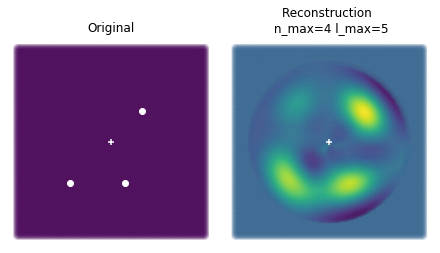

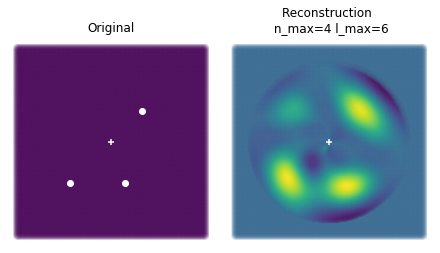

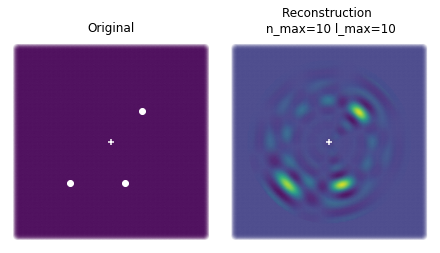

In [18]:
xy = np.array([[0.4,-1.2],[0.9,0.9],[-1.2,-1.2]])
reconstruction_delta(xy,N_points=150,n_max=4,l_max=3)
reconstruction_delta(xy,N_points=150,n_max=4,l_max=4)
reconstruction_delta(xy,N_points=150,n_max=4,l_max=5)
reconstruction_delta(xy,N_points=150,n_max=4,l_max=6)
reconstruction_delta(xy,N_points=150,n_max=10,l_max=10)

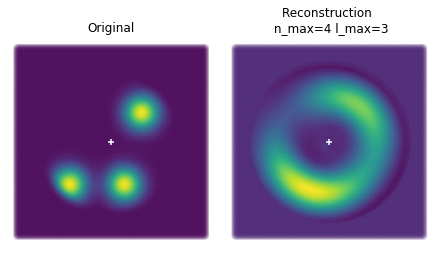

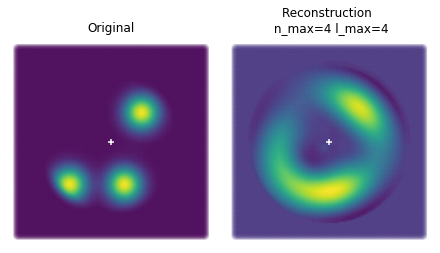

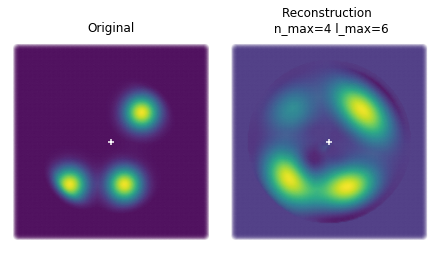

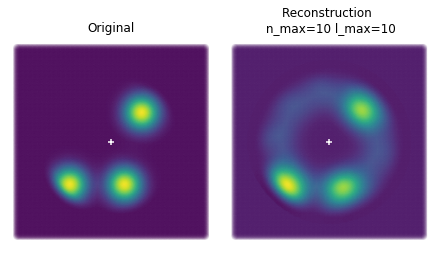

In [19]:
xy = np.array([[0.4,-1.2],[0.9,0.9],[-1.2,-1.2]])
reconstruction(xy,N_points=150,n_max=4,l_max=3)
reconstruction(xy,N_points=150,n_max=4,l_max=4)
reconstruction(xy,N_points=150,n_max=4,l_max=5)
reconstruction(xy,N_points=150,n_max=4,l_max=6)
reconstruction(xy,N_points=150,n_max=10,l_max=10)

#reconstruction(xy,N_points=150,n_max=5,l_max=5)
#reconstruction(xy,N_points=150,n_max=6,l_max=5)
#reconstruction(xy,N_points=150,n_max=7,l_max=5)

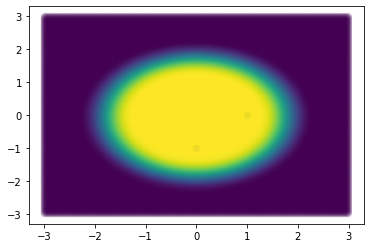

In [37]:
xy = np.array([[0.,-1.],[1.,0.]])
plt.scatter(xy[:,0],xy[:,1])
xx,yy = np.meshgrid(x,y,sparse=False)
rho = shape_function(xx,yy,rcut,d_trans=1.0)
plt.scatter(xx,yy,c=rho,alpha=0.1)
#plt.scatter(xy[:,0],xy[:,1])


[0.054115885822512394, -0.025586244285391014, -0.02558624428539103, -2.0260822396371624e-17, -1.1630285747459651e-17, -0.053886043913764614, 0.025232067042497863, 0.025232067042498082, 1.4194426434957042e-16, -8.62996006087928e-17, 0.03475350036950265, -0.015819774941709833, -0.01581977494171, -1.1873556015484659e-16, -6.071163827288965e-17, -0.004855045442670131, 0.0017084129694827207, 0.0017084129694829727, 2.0602445064974773e-16, -8.764875022966858e-17]


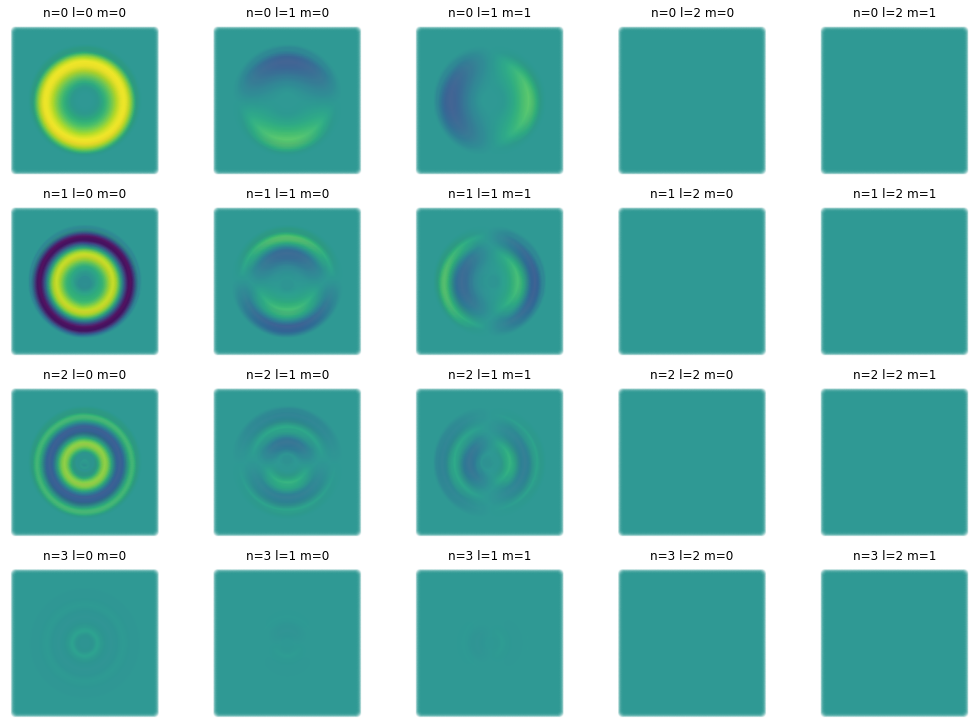

In [16]:
keys_mosaic = reshape_mosaic(basis_dict,n_max,l_max)

fig = plt.figure(constrained_layout=True,frameon=False,figsize=(14,10))

ax_dict = fig.subplot_mosaic(
    keys_mosaic,
)

N_grid = xx.shape[0]*xx.shape[1]
coef = []
cfs  = []
f_min = []
f_max = []
for i,key in enumerate(basis_dict.keys()):
    c = np.sum(fs[i]*rho)/N_grid
    coef.append(c)
    cfs.append(c*fs[i])
    f_min.append(np.min(c*fs[i]))
    f_max.append(np.max(c*fs[i]))
    ax_dict[key].axis('off')
    ax_dict[key].set_title(key)
    ax_dict[key].set_aspect('equal')

f_min = min(f_min)
f_max = max(f_max)    
print(coef)    
for i,key in enumerate(basis_dict.keys()):    
    ax_dict[key].scatter(xx,yy,c=cfs[i],alpha=0.05,vmin=f_min,vmax=f_max)

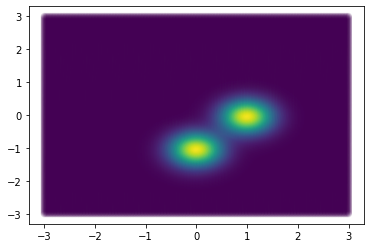

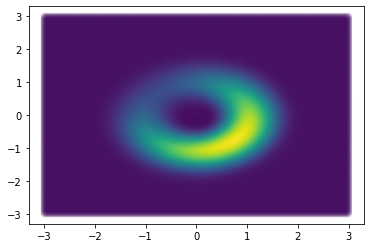

In [17]:
recon = np.zeros_like(xx)
for cf in cfs:
    recon += cf
plt.scatter(xx,yy,c=rho,alpha=0.1)
plt.show()
plt.scatter(xx,yy,c=recon,alpha=0.1)
plt.show()